# *Proyecto de Deep Learning*
---

##  *Enfoque clasificacion Multiclase*

 ### 📌 ***Objetivos:***

*Extender el modelo para predecir el engagement turístico en múltiples niveles cualitativos (Muy Bajo, Bajo, Alto, Muy Alto), generando una clasificación más detallada y útil para estrategias de promoción turística.*

***Propósito específico:***
- *Evaluar cómo la granularidad en las etiquetas mejora la capacidad del modelo para capturar matices en el comportamiento del usuario.*
- *Permitir una segmentación más rica de los POIs en función de su atractivo esperado.*
- *Adaptar la arquitectura y las funciones de pérdida a un escenario multiclase, incorporando métricas específicas como accuracy multiclase, matriz de confusión, y macro/micro F1-score*

---

## 1. Estructura de los datos

In [1]:
# Imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import cv2
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
import torchvision
from torchvision import datasets, transforms
from PIL import Image

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split


from PIL import Image
import os
from google.colab import drive
from itertools import chain
import ast
import folium
import folium.plugins as plugins

In [2]:
# Conectar a Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Ruta al archivo CSV con metadatos
csv_path = '/content/drive/MyDrive/Deep Learning/Proyecto/poi_dataset.csv'
df = pd.read_csv(csv_path)

# Visualizamos las primeras filas
df.head().T


,0,1,2,3,4
id,4b36a3ed-3b28-4bc7-b975-1d48b586db03,e32b3603-a94f-49df-8b31-92445a86377c,0123a69b-13ac-4b65-a5d5-71a95560cff5,390d7d9e-e972-451c-b5e4-f494af15e788,023fc1bf-a1cd-4b9f-af78-48792ab1a294
name,Galería Fran Reus,Convento de San Plácido,Instituto Geológico y Minero de España,Margarita Gil Roësset,Museo del Traje. Centro de Investigación del P...
shortDescription,La Galería Fran Reus es un espacio dedicado a ...,"El Convento de San Plácido en Madrid, fundado ...","El Instituto Geológico y Minero de España, sit...","Margarita Gil Roësset, escultora y poetisa esp...","El Museo del Traje de Madrid, fundado en 2004,..."
categories,"['Escultura', 'Pintura']","['Patrimonio', 'Historia']","['Ciencia', 'Patrimonio']",['Cultura'],"['Patrimonio', 'Cultura']"
tier,1,1,2,1,1
locationLon,2.642262,-3.704467,-3.699694,-3.691228,-3.727822
locationLat,39.572694,40.423037,40.442045,40.427256,40.439665
tags,[],[],[],[],[]
xps,500,500,250,500,500
Visits,10009,10010,10015,10011,10020


In [ ]:
#Craemos ruta al directorio del proyecto
root_dir = '/content/drive/MyDrive/Deep Learning/Proyecto'

#Nueva columna con  la ruta directa
df['image_full_path'] = df['main_image_path'].apply(lambda x: os.path.join(root_dir, x.strip('/')))

#Confirmacion
print(df['image_full_path'].iloc[0])
print(os.path.exists(df['image_full_path'].iloc[0]))

/content/drive/MyDrive/Deep Learning/Proyecto/data_main/4b36a3ed-3b28-4bc7-b975-1d48b586db03/main.jpg
True


In [ ]:
print("Dimensiones de los datos:",df.shape)
print("\n Tipos de datos:", df.dtypes)

Dimensiones de los datos: (1569, 15)

 Tipos de datos: id                   object
name                 object
shortDescription     object
categories           object
tier                  int64
locationLon         float64
locationLat         float64
tags                 object
xps                   int64
Visits                int64
Likes                 int64
Dislikes              int64
Bookmarks             int64
main_image_path      object
image_full_path      object
dtype: object



---

## 2. *Feature Engineering*

In [ ]:
# Valores faltantes
df = df[~df['tags'].apply(lambda x: x.strip() == '[]')].reset_index(drop=True)
print("¿Quedan listas vacías?", df['tags'].apply(lambda x: x.strip() == '[]').any())

¿Quedan listas vacías? False


In [ ]:
print("Tamaño final del DataFrame:", len(df))

Tamaño final del DataFrame: 1462


In [5]:
print(df['categories'].apply(lambda x: len(x.split(','))).value_counts())
# Nos indica la cantidad de etiquetas en string que tienen las filas; ejemplo:
# "['Escultura', 'Cultura', 'Historia']"-> 3 valores en -> 1073 filas

print(df['categories'].iloc[0])
print(type(df['categories'].iloc[0]))

categories
3    1073
4     325
2     106
1      65
Name: count, dtype: int64
['Escultura', 'Pintura']
<class 'str'>


In [6]:
df['categories_list'] = df['categories'].apply(lambda x: ast.literal_eval(x))

valores_unicos = set(chain.from_iterable(df['categories_list']))
print("Valores únicos:", valores_unicos)

Valores únicos: {'Gastronomía', 'Patrimonio', 'Naturaleza', 'Ocio', 'Cine', 'Ciencia', 'Arquitectura', 'Misterio', 'Cultura', 'Historia', 'Pintura', 'Escultura'}


In [7]:
mlb = MultiLabelBinarizer()
category_encoded = mlb.fit_transform(df['categories_list'])

# Convertimos a DataFrame
category_df = pd.DataFrame(category_encoded, columns=mlb.classes_)

# Concatenamos al dataset original
df = pd.concat([df, category_df], axis=1)
print(mlb.classes_)

['Arquitectura' 'Ciencia' 'Cine' 'Cultura' 'Escultura' 'Gastronomía'
 'Historia' 'Misterio' 'Naturaleza' 'Ocio' 'Patrimonio' 'Pintura']


In [8]:
# Vamos a extraer los tags individuales y usar los más frecuentes como features binarios.

def convertir_a_lista(cadena):
    try:
        valor = ast.literal_eval(cadena)
        if isinstance(valor, list):
            return valor
        else:
            return [str(valor)]
    except:
        return [str(cadena)]

df['tags_list'] = df['tags'].apply(convertir_a_lista)


In [9]:
from collections import Counter

todos_tags = list(chain.from_iterable(df['tags_list']))
contadores = Counter(todos_tags)

top_tags = [tag for tag, count in contadores.most_common(20)]
print(top_tags)

# generar columnas booleanas
for tag in top_tags:
    df[f'tag_{tag}'] = df['tags_list'].apply(lambda lista: int(tag in lista))

['Historia', 'Madrid', 'Cultura', 'Arquitectura', 'Patrimonio', 'Arte', 'Escultura', 'Estatua', 'Monumento', 'Naturaleza', 'Restauración', 'Grupo escultórico', 'Educación', 'Escultura conceptual o abstracta', 'Centro', 'Retiro', 'Turismo', 'Galicia', 'Homenaje', 'Jerónimos']


In [10]:
#Generar columna de cluesters para variables espaciales
from sklearn.cluster import KMeans

# Seleccionar las columnas de coordenadas
coords = df[['locationLon', 'locationLat']].values

# Definir número de clusters (ejemplo: 5)
n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['geo_cluster'] = kmeans.fit_predict(coords)

In [11]:
# Creacion del target

df['engagement_score'] = (
    df['Visits'] +
    df['Likes'] * 2 +  # mayor peso a likes
    df['Bookmarks'] * 1.5 -
    df['Dislikes'] * 1  # penalizar dislikes
)

df['engagement_label_multiclass'] = pd.qcut(
    df['engagement_score'],
    q=4,
    labels=[0, 1, 2, 3]
).astype(int)

In [12]:
# Comprobar balance de los datos
df['engagement_label_multiclass'].value_counts(normalize=True)

,proportion
engagement_label_multiclass,
0,0.250478
3,0.249841
2,0.249841
1,0.249841


<Axes: xlabel='engagement_label_multiclass', ylabel='count'>

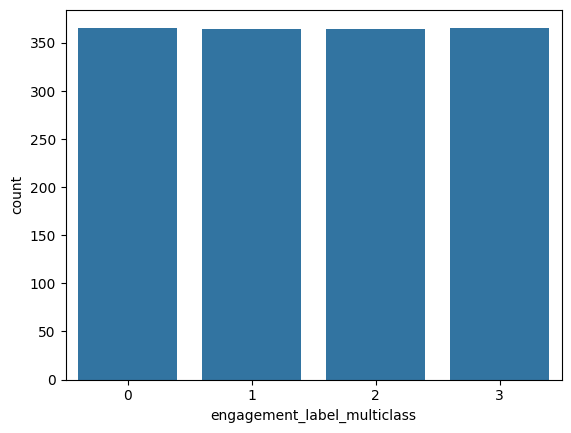

In [ ]:
sns.countplot(data=df, x='engagement_label_multiclass')

In [13]:
df['n_tags']= df['tags'].apply(lambda x: len(x.split(',')))

In [14]:
# Disminucion de columnas
df.drop(columns=['categories', 'categories_list', 'main_image_path',
                 'name','id','shortDescription','engagement_score',
                 'tags_list', 'n_tags','tags','Visits', 'Likes', 'Dislikes', 'Bookmarks'], inplace=True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1569 entries, 0 to 1568
Data columns (total 38 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   tier                                  1569 non-null   int64  
 1   locationLon                           1569 non-null   float64
 2   locationLat                           1569 non-null   float64
 3   xps                                   1569 non-null   int64  
 4   Arquitectura                          1569 non-null   int64  
 5   Ciencia                               1569 non-null   int64  
 6   Cine                                  1569 non-null   int64  
 7   Cultura                               1569 non-null   int64  
 8   Escultura                             1569 non-null   int64  
 9   Gastronomía                           1569 non-null   int64  
 10  Historia                              1569 non-null   int64  
 11  Misterio         

***Imagenes***:
- Media por canal: tensor([0.4451, 0.4412, 0.4202])
- STD por canal: tensor([0.1908, 0.1909, 0.2015])

In [ ]:
#Division
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42, stratify=df['engagement_label_multiclass'])
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42, stratify=df_temp['engagement_label_multiclass'])


---

# 3. *Modelo Multimodal*

1. *CNN - Red de neuronas convolucionales*
2. *Red neuronal para metadatos*
3. *Fusion de modalidades*

In [ ]:
# Normalizacion datos geograficos solo a train
scaler = StandardScaler()
scaler.fit(df_train[['locationLon', 'locationLat']])

# Transformar todos los conjuntos
df_train[['locationLon', 'locationLat']] = scaler.transform(df_train[['locationLon', 'locationLat']])
df_val[['locationLon', 'locationLat']] = scaler.transform(df_val[['locationLon', 'locationLat']])
df_test[['locationLon', 'locationLat']] = scaler.transform(df_test[['locationLon', 'locationLat']])

In [ ]:
# Definimos las transformaciones para entrenamiento (con data augmentation)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4451, 0.4412, 0.4202], std=[0.1908, 0.1909, 0.2015])
])


# Definimos transformaciones para validación y test (solo normalización)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4451, 0.4412, 0.4202], std=[0.1908, 0.1909, 0.2015])
    ])

In [ ]:
# Clase POIDataset modificada para multiclase

class POIDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

        # Usamos todas las columnas numéricas como metadatos (excepto imagen y etiquetas)
        self.metadata_cols = [
            col for col in dataframe.columns
            if col not in ['image_full_path', 'engagement_label_multiclass']
        ]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Cargar y transformar imagen
        img_path = row['image_full_path']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Procesar metadatos
        metadata_vals = row[self.metadata_cols].values.astype(np.float32)
        metadata = torch.tensor(metadata_vals, dtype=torch.float32)

        # Etiqueta multiclase: 0, 1, 2, 3
        label = torch.tensor(row['engagement_label_multiclass'], dtype=torch.long)

        return image, metadata, label

In [ ]:
#------------------------------
# Red Convolucional para imágenes
#-----------------------------

class VisualCNN(nn.Module):
    def __init__(self):
        super(VisualCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # input 3x128x128
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32x64x64

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64x32x32

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 128x16x16
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 16 * 16, 256)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


# ----------------------------
# Red para metadatos tabulares
#----------------------------

class TabularNN(nn.Module):
    def __init__(self, input_dim):
        super(TabularNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )

    def forward(self, x):
        return self.net(x)


# ---------------------
# Red multimodal fusionada para clasificación multiclase
#---------------------

class MultimodalNet(nn.Module):
    def __init__(self, input_dim, num_classes=4):
        super(MultimodalNet, self).__init__()
        self.visual_net = VisualCNN()
        self.tabular_net = TabularNN(input_dim)
        self.classifier = nn.Sequential(
            nn.Linear(256 + 32, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)  # salida para 4 clases, sin activación
        )

    def forward(self, image, tabular):
        image_features = self.visual_net(image)
        tabular_features = self.tabular_net(tabular)
        combined = torch.cat((image_features, tabular_features), dim=1)
        return self.classifier(combined)


In [ ]:
# Crear Dataset y Dataloaders
train_dataset = POIDataset(df_train, transform=transform_train)
val_dataset = POIDataset(df_val, transform=transform_test)
test_dataset = POIDataset(df_test, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Imprimir tamaños de los datasets
print(f"Tamaño del conjunto de entrenamiento: {len(train_dataset)}")
print(f"Tamaño del conjunto de validación: {len(val_dataset)}")
print(f"Tamaño del conjunto de test: {len(test_dataset)}")

Tamaño del conjunto de entrenamiento: 1023
Tamaño del conjunto de validación: 219
Tamaño del conjunto de test: 220


## 4. *Entrenamiento y evaluacion*

In [ ]:
# Funciones de entrenamiento de epocas

def train_epoch(model, device, dataloader, criterion, optimizer):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, metadata, labels in dataloader:
        images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images, metadata)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


def eval_epoch(model, device, dataloader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, metadata, labels in dataloader:
            images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
            outputs = model(images, metadata)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return running_loss / total, correct / total, all_preds, all_labels

In [ ]:
def eval_model(model, dataloader, criterion, device):
    model.eval()
    eval_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, metadata, labels in dataloader:
            images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
            outputs = model(images, metadata)
            loss = criterion(outputs, labels)

            eval_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = eval_loss / total
    accuracy = correct / total

    return avg_loss, accuracy, all_preds, all_labels

In [ ]:

def train_model(model, train_loader, val_loader, num_epochs, lr, device):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        for images, metadata, labels in train_loader:
            images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, metadata)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

     # Evaluación en validación
        val_loss, val_acc, _, _ = eval_model(model, val_loader, criterion, device)

        epoch_train_loss = train_loss / train_total
        epoch_train_acc = train_correct / train_total

        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history


In [ ]:
def test_model(model, test_loader, device):
    criterion = nn.CrossEntropyLoss()
    test_loss, test_acc, preds, labels = eval_model(model, test_loader, criterion, device)

    print(f"\n📊 Test Accuracy: {test_acc:.4f}")
    print(classification_report(labels, preds, target_names=["Muy Bajo", "Bajo", "Alto", "Muy Alto"]))



---


In [ ]:
def plot_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(14, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss', marker='o')
    plt.plot(epochs, history['val_loss'], label='Val Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy', marker='o')
    plt.plot(epochs, history['val_acc'], label='Val Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
#Definir dimensiones y device

input_dim = len(train_dataset.metadata_cols)  # cantidad de features tabulares
num_classes = 4  # Muy Bajo, Bajo, Alto, Muy Alto
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Instanciar modelo multimodal
model = MultimodalNet(input_dim=input_dim, num_classes=num_classes)

Epoch 1/15 | Train Loss: 1.4871, Train Acc: 0.2688 | Val Loss: 1.4223, Val Acc: 0.2877
Epoch 2/15 | Train Loss: 1.3099, Train Acc: 0.3646 | Val Loss: 1.3295, Val Acc: 0.3562
Epoch 3/15 | Train Loss: 1.2465, Train Acc: 0.4203 | Val Loss: 1.3035, Val Acc: 0.3562
Epoch 4/15 | Train Loss: 1.2215, Train Acc: 0.4330 | Val Loss: 1.2244, Val Acc: 0.4247
Epoch 5/15 | Train Loss: 1.2073, Train Acc: 0.4477 | Val Loss: 1.2724, Val Acc: 0.3744
Epoch 6/15 | Train Loss: 1.1524, Train Acc: 0.4907 | Val Loss: 1.3229, Val Acc: 0.3562
Epoch 7/15 | Train Loss: 1.1161, Train Acc: 0.4946 | Val Loss: 1.3154, Val Acc: 0.3836
Epoch 8/15 | Train Loss: 1.1082, Train Acc: 0.5152 | Val Loss: 1.1665, Val Acc: 0.4658
Epoch 9/15 | Train Loss: 1.0638, Train Acc: 0.5445 | Val Loss: 1.1305, Val Acc: 0.5297
Epoch 10/15 | Train Loss: 1.0566, Train Acc: 0.5406 | Val Loss: 1.1428, Val Acc: 0.5434
Epoch 11/15 | Train Loss: 1.0403, Train Acc: 0.5543 | Val Loss: 1.1170, Val Acc: 0.5388
Epoch 12/15 | Train Loss: 0.9989, Train A

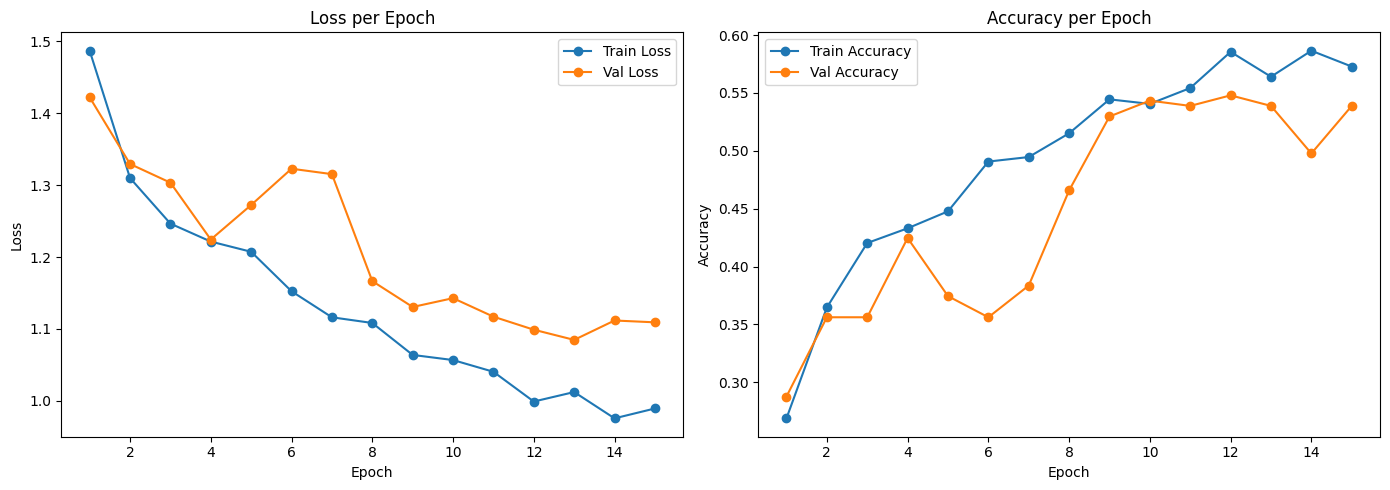


📊 Test Accuracy: 0.5818
              precision    recall  f1-score   support

    Muy Bajo       0.53      0.38      0.44        55
        Bajo       0.49      0.51      0.50        55
        Alto       0.57      0.64      0.60        55
    Muy Alto       0.71      0.80      0.75        55

    accuracy                           0.58       220
   macro avg       0.57      0.58      0.57       220
weighted avg       0.57      0.58      0.57       220



In [ ]:
# Entrenamiento del modelo

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=15,
    lr=1e-4,
    device=device
)


# Visualización de curvas
plot_training_curves(history)

# Evaluación final en test
test_model(model, test_loader, device)


Epoch 1/20 | Train Loss: 1.4724, Train Acc: 0.3617 | Val Loss: 1.2636, Val Acc: 0.4201
Epoch 2/20 | Train Loss: 1.1875, Train Acc: 0.4692 | Val Loss: 1.2169, Val Acc: 0.4521
Epoch 3/20 | Train Loss: 1.1414, Train Acc: 0.4712 | Val Loss: 1.2272, Val Acc: 0.4795
Epoch 4/20 | Train Loss: 1.0988, Train Acc: 0.5132 | Val Loss: 1.3037, Val Acc: 0.4338
Epoch 5/20 | Train Loss: 1.0875, Train Acc: 0.5103 | Val Loss: 1.1329, Val Acc: 0.5251
Epoch 6/20 | Train Loss: 1.0250, Train Acc: 0.5630 | Val Loss: 1.0876, Val Acc: 0.5616
Epoch 7/20 | Train Loss: 1.0074, Train Acc: 0.5767 | Val Loss: 1.0975, Val Acc: 0.5479
Epoch 8/20 | Train Loss: 1.0175, Train Acc: 0.5611 | Val Loss: 1.1333, Val Acc: 0.4840
Epoch 9/20 | Train Loss: 1.0026, Train Acc: 0.5601 | Val Loss: 1.0422, Val Acc: 0.5799
Epoch 10/20 | Train Loss: 0.9782, Train Acc: 0.5982 | Val Loss: 1.0497, Val Acc: 0.5708
Epoch 11/20 | Train Loss: 0.9429, Train Acc: 0.5904 | Val Loss: 1.0787, Val Acc: 0.5616
Epoch 12/20 | Train Loss: 0.9263, Train A

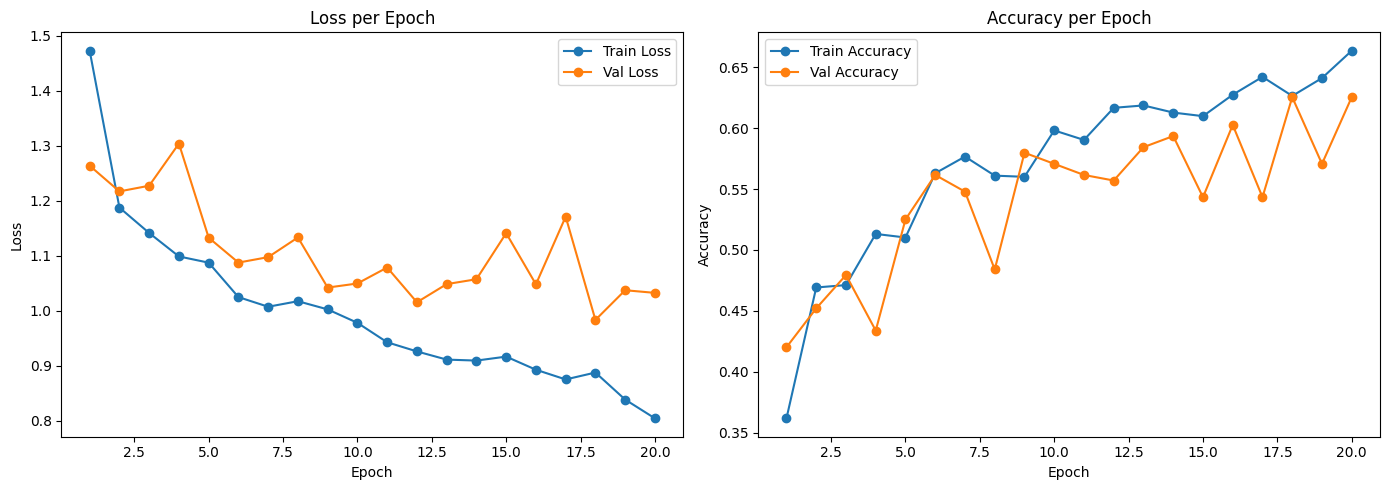


📊 Test Accuracy: 0.5773
              precision    recall  f1-score   support

    Muy Bajo       0.49      0.38      0.43        55
        Bajo       0.48      0.64      0.55        55
        Alto       0.61      0.62      0.61        55
    Muy Alto       0.77      0.67      0.72        55

    accuracy                           0.58       220
   macro avg       0.59      0.58      0.58       220
weighted avg       0.59      0.58      0.58       220



In [ ]:
# Entrenamiento del modelo learning rate mas alto y mas epocas
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=20,
    lr=0.001,
    device=device
)

# Visualización de curvas
plot_training_curves(history)

# Evaluación final en test
test_model(model, test_loader, device)

Epoch 1/50 | Train Loss: 7.6438, Train Acc: 0.2786 | Val Loss: 1.3920, Val Acc: 0.2511
Epoch 2/50 | Train Loss: 1.4569, Train Acc: 0.2493 | Val Loss: 1.3871, Val Acc: 0.1918
Epoch 3/50 | Train Loss: 1.3952, Train Acc: 0.2561 | Val Loss: 1.3871, Val Acc: 0.2511
Epoch 4/50 | Train Loss: 1.3872, Train Acc: 0.2493 | Val Loss: 1.3865, Val Acc: 0.2511
Epoch 5/50 | Train Loss: 1.3872, Train Acc: 0.2493 | Val Loss: 1.3863, Val Acc: 0.2511
Epoch 6/50 | Train Loss: 1.3868, Train Acc: 0.2434 | Val Loss: 1.3863, Val Acc: 0.2466
Epoch 7/50 | Train Loss: 1.3869, Train Acc: 0.2366 | Val Loss: 1.3863, Val Acc: 0.2511
Epoch 8/50 | Train Loss: 1.3869, Train Acc: 0.2219 | Val Loss: 1.3863, Val Acc: 0.2511
Epoch 9/50 | Train Loss: 1.3873, Train Acc: 0.2405 | Val Loss: 1.3863, Val Acc: 0.2511
Epoch 10/50 | Train Loss: 1.3867, Train Acc: 0.2532 | Val Loss: 1.3863, Val Acc: 0.2511
Epoch 11/50 | Train Loss: 1.3871, Train Acc: 0.2395 | Val Loss: 1.3864, Val Acc: 0.2511
Epoch 12/50 | Train Loss: 1.3870, Train A

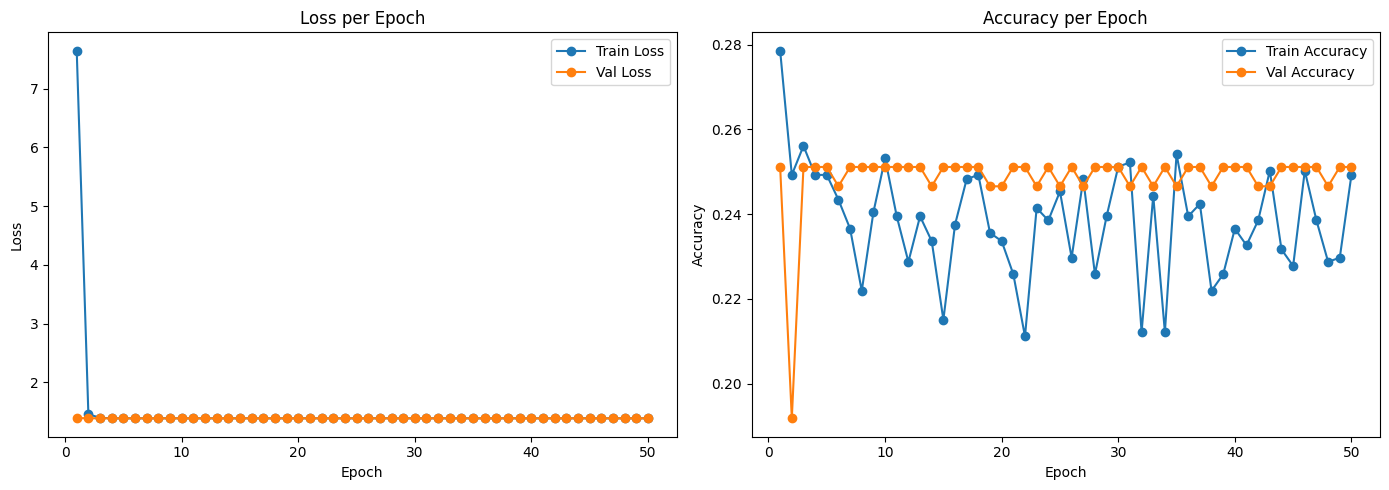


📊 Test Accuracy: 0.2500
              precision    recall  f1-score   support

    Muy Bajo       0.00      0.00      0.00        55
        Bajo       0.00      0.00      0.00        55
        Alto       0.00      0.00      0.00        55
    Muy Alto       0.25      1.00      0.40        55

    accuracy                           0.25       220
   macro avg       0.06      0.25      0.10       220
weighted avg       0.06      0.25      0.10       220



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Entrenamiento del modelo learning rate mas alto y mas epocas
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=50,
    lr=0.01,
    device=device
)

# Visualización de curvas
plot_training_curves(history)

# Evaluación final en test
test_model(model, test_loader, device)